<a href="https://colab.research.google.com/github/nicolassalomon96/Traffic_sign_classifier/blob/main/Scripts/Traffic_sign_classifier_(Model_test).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador de Señales de Tránsito empleando redes nueronales convolucionales

Nombre y Apellido: Nicolás Salomón

Email: nicolassalomon96@gmail.com

En el presente notebook se realizará la prueba final sobre el modelo que mejor resultados obtuvo.

#1. Librerias necesarias

In [ ]:
import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
import imageio as io
import pandas as pd
import pickle
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

##1.1. Acceso a Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#2. Importar dataset y generar el modelo 

In [ ]:
!unzip '/content/drive/MyDrive/Posgrado/traffic_sign_detection/traffic_sign_classifier/Dataset/GTSRD_mod.zip' -d "/content/dataset" > /dev/null 

In [ ]:
#Función para leer las imagenes y labels del dataset
def load_images(path_images_folder, path_labels_file):
    #path_images_folder: path a la carpeta donde estan las imágenes
    #path_labels_file: path al archivo .pickle con los labels de las imágenes
    images = []
    labels = pd.read_pickle(path_labels_file) #Leo las etiquetas del set de entrenamiento guardadas
    images_count = len(labels)
 
    for i in range(images_count):
      image_path = os.path.join(path_images_folder, f'image_{i}.png') #crea el path completo de la imagen
      image = cv2.imread(image_path).astype('uint8')
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      #Actualizo la lista de imagenes y de labels
      images.append(image)

    images = np.array(images, dtype='uint8')
    return images, labels

#Función para leer el archivo .csv del dataset que continene las clases a clasificar  
def load_class_names(path_directory):
    path_class_names =  os.path.join(path_directory,"class_names.csv")
    class_names = open(path_class_names).read().strip().split("\n")[1:]
    class_names = [l.split(',')[1] for l in class_names] #creo una lista con los nombres de cada label
    return class_names

In [ ]:
test_images_folder = '/content/dataset/test_images_mod'
test_labels_file = '/content/dataset/test_labels_mod.pickle'
class_names_path = "/content/dataset"

test_images, test_labels = load_images(test_images_folder, test_labels_file)
class_names = load_class_names(class_names_path)

In [ ]:
#Creamos el modelo de la CNN_custom, con un modelo preentrenado
CNN_custom = keras.models.load_model('/content/drive/MyDrive/Posgrado/traffic_sign_detection/traffic_sign_classifier/Models/CNN_custom_leakyrelu_adam.h5')
print("Modelo creado")

Modelo creado


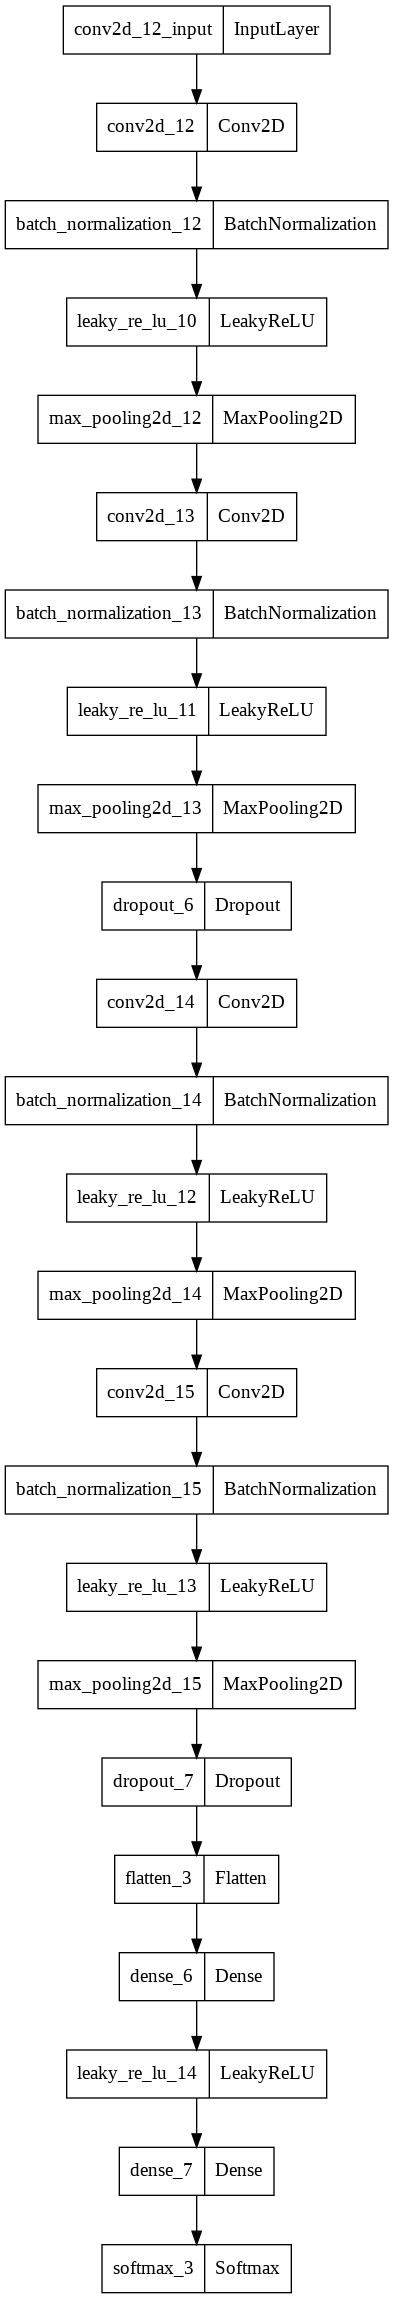

In [ ]:
keras.utils.plot_model(CNN_custom)

                               precision    recall  f1-score   support

         Speed limit (20km/h)       0.98      0.92      0.95        60
         Speed limit (30km/h)       0.98      0.99      0.99       720
         Speed limit (50km/h)       1.00      0.99      0.99       750
         Speed limit (60km/h)       1.00      0.96      0.98       450
         Speed limit (70km/h)       1.00      0.98      0.99       660
         Speed limit (80km/h)       0.96      0.99      0.97       630
  End of speed limit (80km/h)       1.00      0.98      0.99       150
        Speed limit (100km/h)       0.98      0.99      0.99       450
        Speed limit (120km/h)       0.99      0.98      0.98       450
                   No passing       1.00      1.00      1.00       480
     No passing heavy vehicle       0.99      1.00      0.99       660
 Right-of-way at intersection       0.93      0.98      0.95       420
                Priority road       0.99      0.98      0.98       690
     

Text(122.99999999999999, 0.5, 'Predicción')

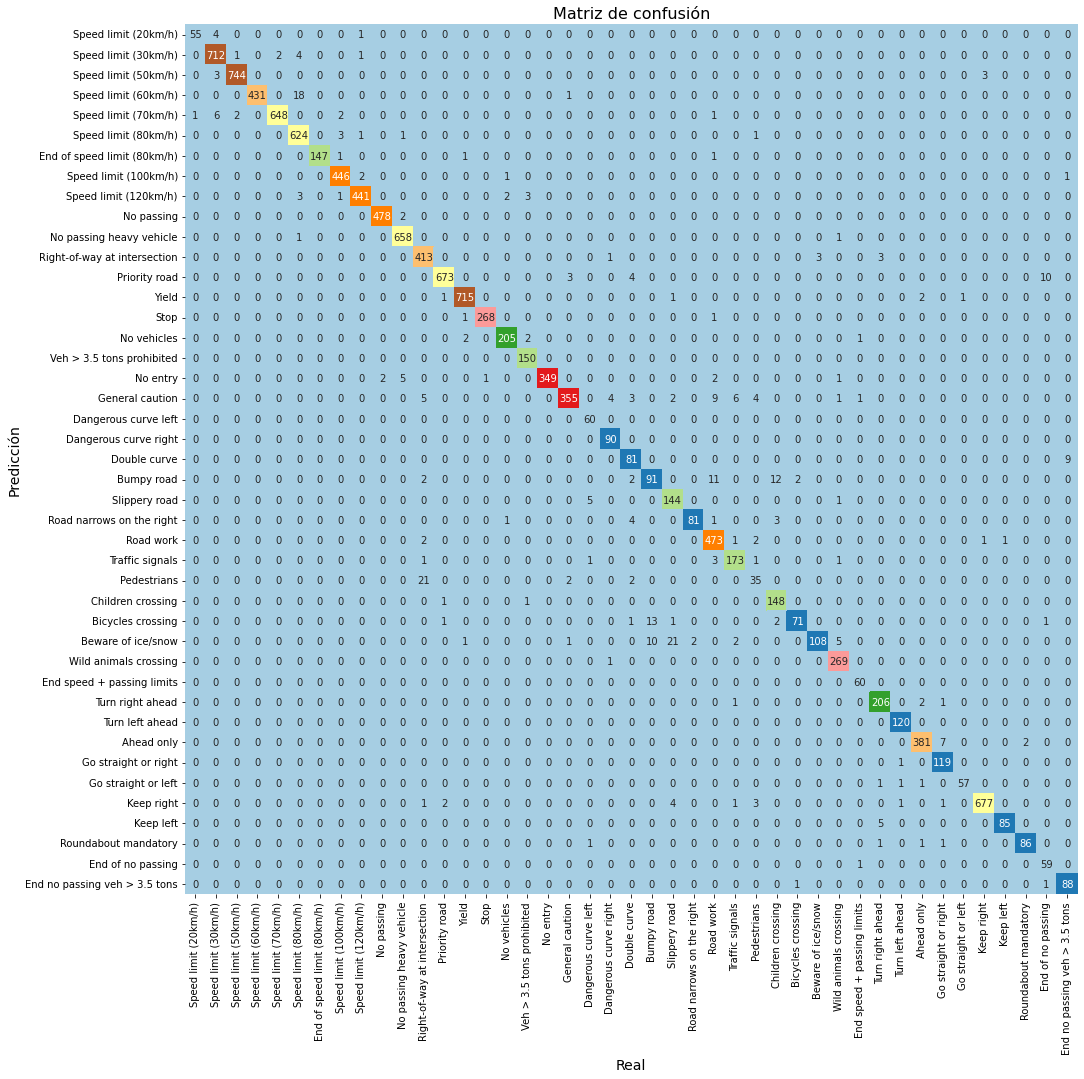

In [ ]:
#Métricas empleadas
pred_custom = np.argmax(CNN_custom.predict(test_images), axis = 1)

labels = [class_names[i] for i in range(43)]
print(classification_report(test_labels, pred_custom, target_names = labels))

cmat_custom = confusion_matrix(test_labels, pred_custom)
plt.figure(figsize=(16,16))
sns.heatmap(cmat_custom, annot = True, cbar = False, cmap='Paired', fmt="d", xticklabels=labels, yticklabels=labels)
plt.title('Matriz de confusión', fontsize=16)
plt.xlabel('Real', fontsize=14)
plt.ylabel('Predicción', fontsize=14)

#3. Pruebas con imágenes descargadas de internet

In [ ]:
#Función para leer las imágenes previamente descargadas de internet
def load_test_images(path_test):
    test_images = []
    files = os.listdir(path_test)
    for image_name in files: 
        image_path = os.path.join(path_test, image_name) #crea el path completo de la imagen
        image = io.imread(image_path) 
        if image.shape[0] != 64 or image.shape[1] != 64:
          image = cv2.resize(image,(64,64))
        if image.shape[2] == 4:
          image = image[:,:,:3]

        #Actualizo la lista de imagenes
        test_images.append(image)
    
    return test_images

In [ ]:
class_names_path = "/content/drive/MyDrive/Posgrado/traffic_sign_detection/traffic_sign_classifier/Dataset"
class_names = load_class_names(class_names_path)

path_test = '/content/drive/MyDrive/Posgrado/traffic_sign_detection/traffic_sign_classifier/custom_signs'
test_images = load_test_images(path_test)

In [ ]:
#Función para generar la inferencia empleando el modelo generado sobre un lote de imagenes
def test(load_images,model,classes):
  fig,axs = plt.subplots(5,len(load_images)//5,figsize=(25,25))
  total = len(load_images)

  for i in range(total):
    image = np.copy(load_images[i])
    #Agregamos una dimension ya que el modelo de CNN entrenado recibe un lote de imagenes para clasificar (shape: (nº imagenes, alto, ancho, canales))
    image = np.expand_dims(image, axis=0) #shape: (1,32,32,3)
    prediction1 = model.predict(image)
    plt.subplot(5,len(load_images)//5,i+1)
    image = np.squeeze(image,axis=0)
    plt.imshow(image)
    sign_class = classes[np.argmax(prediction1)]
    plt.title(f"{sign_class} {round(prediction1[0][np.argmax(prediction1)]*100,2)}%")
  plt.show()

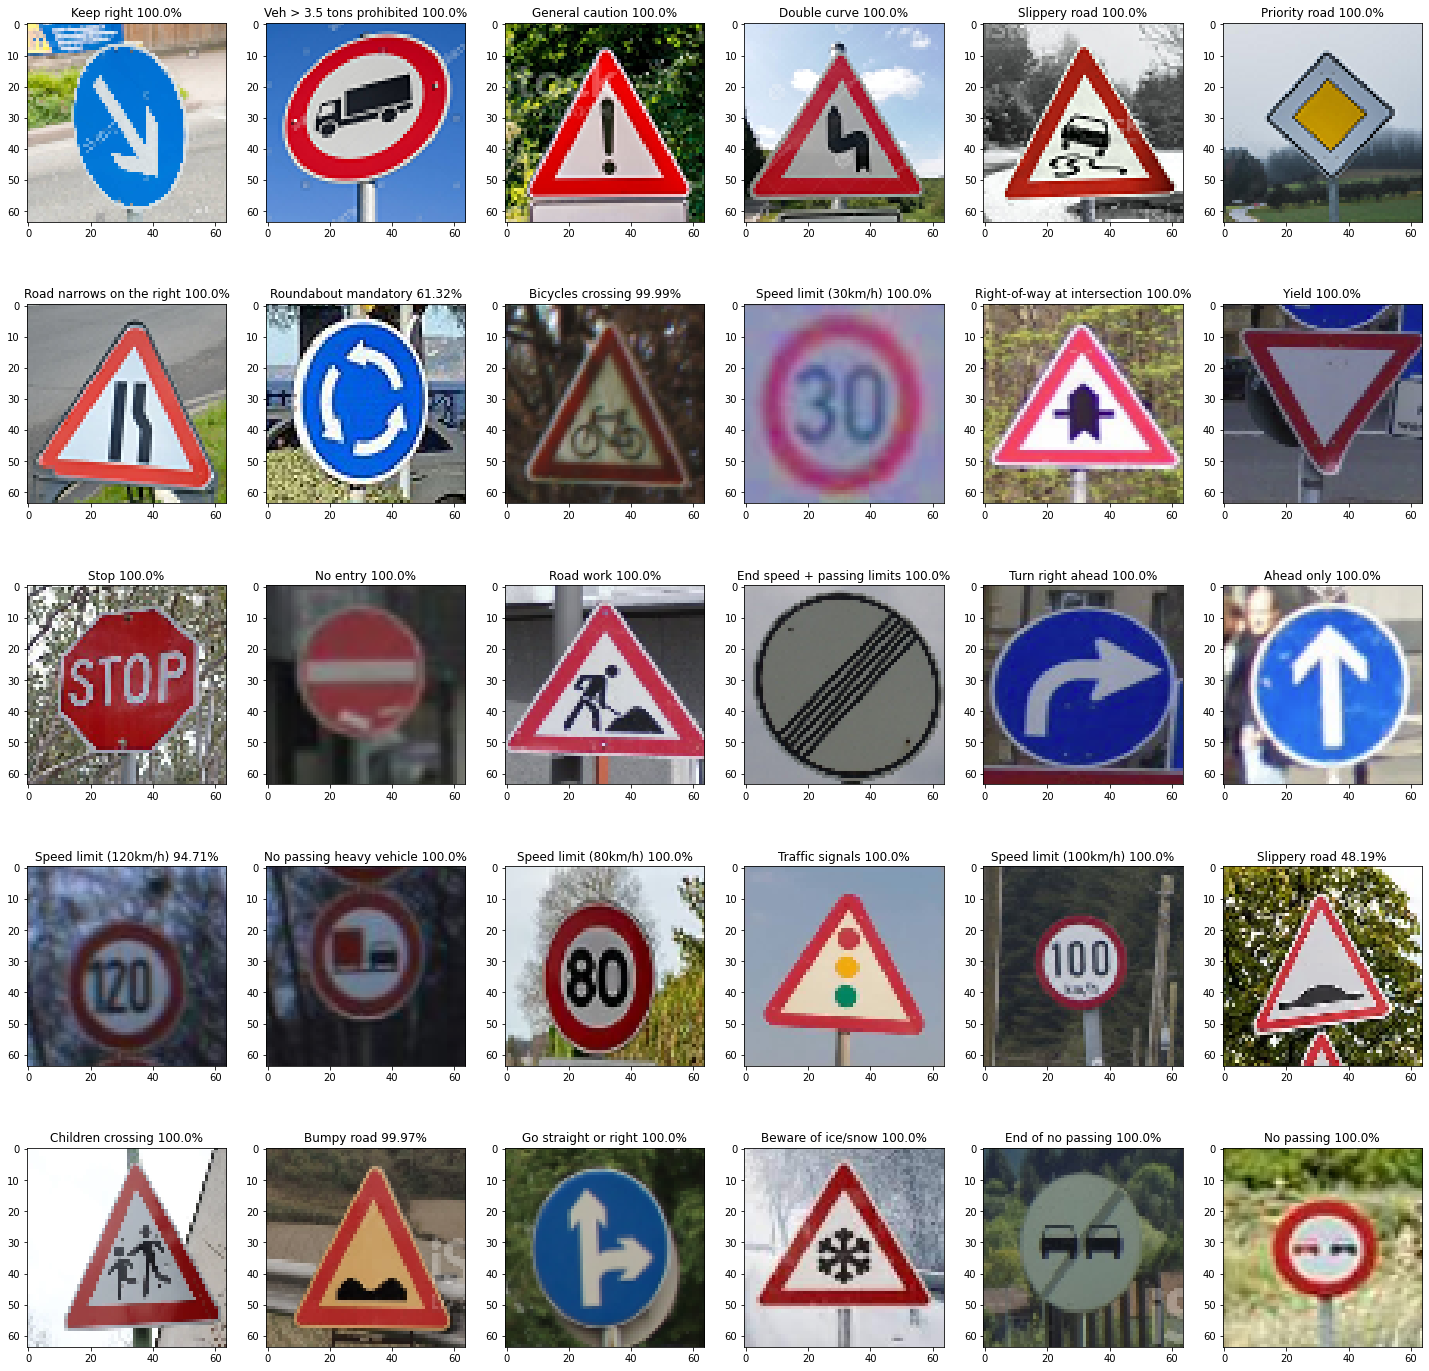

In [ ]:
test(test_images, CNN_custom, class_names)

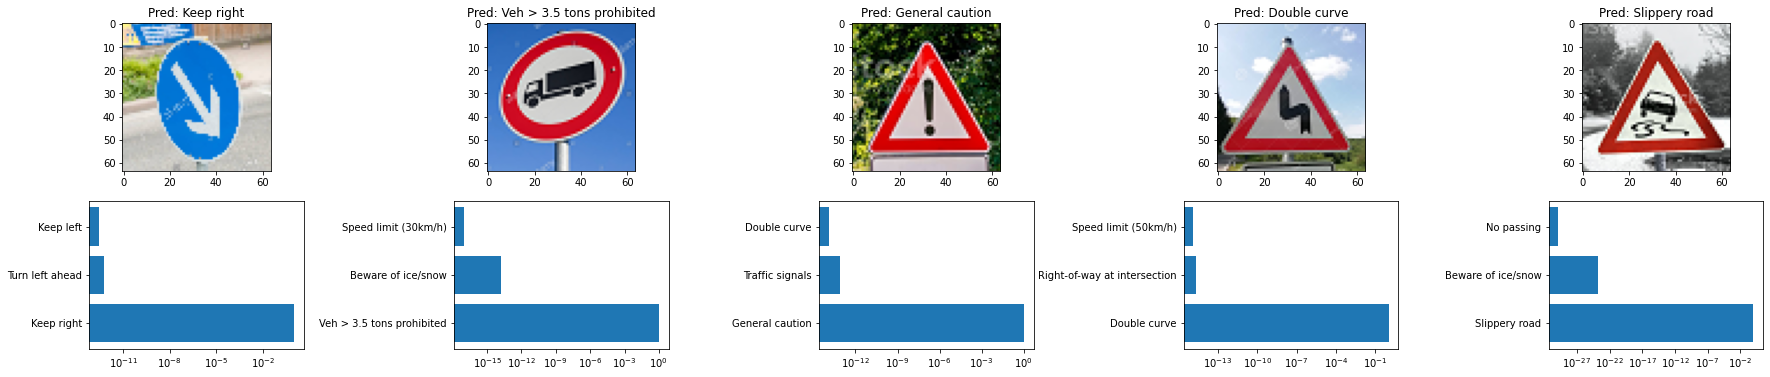

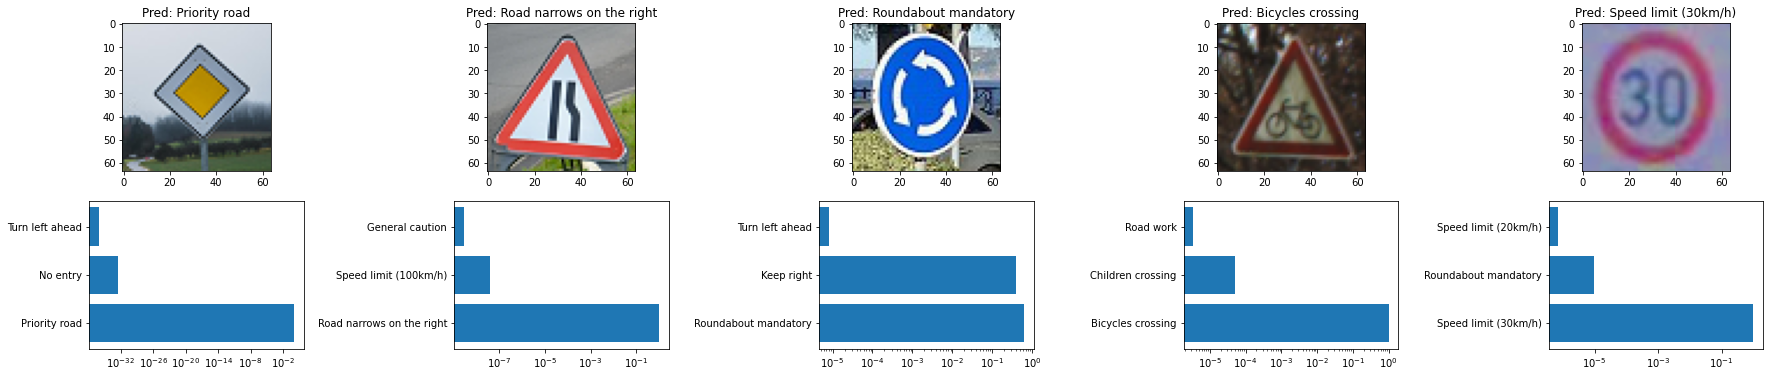

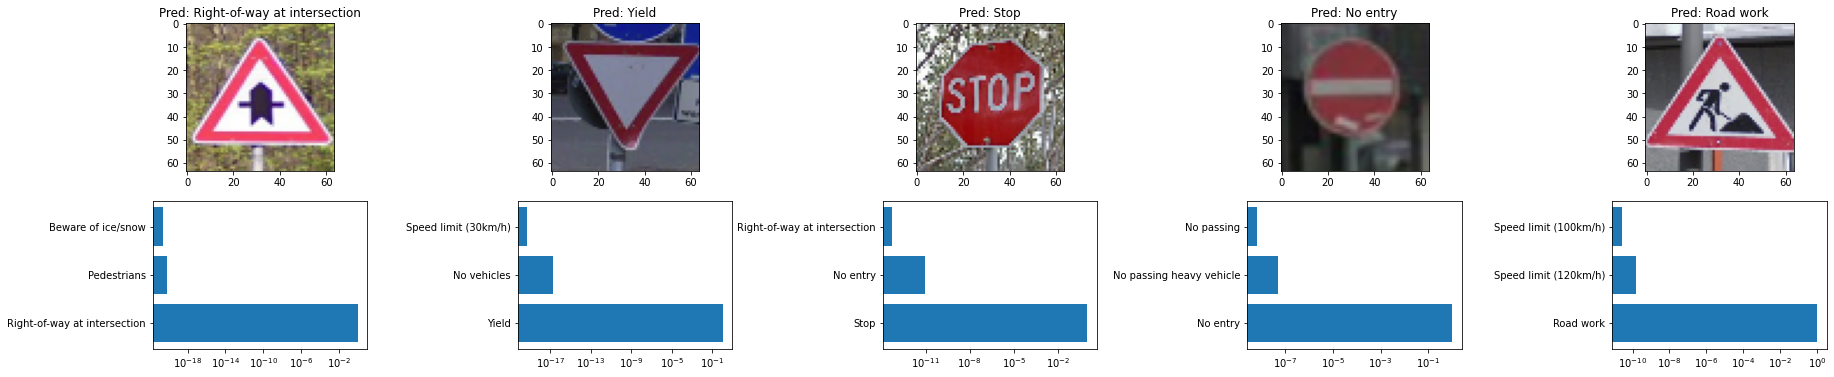

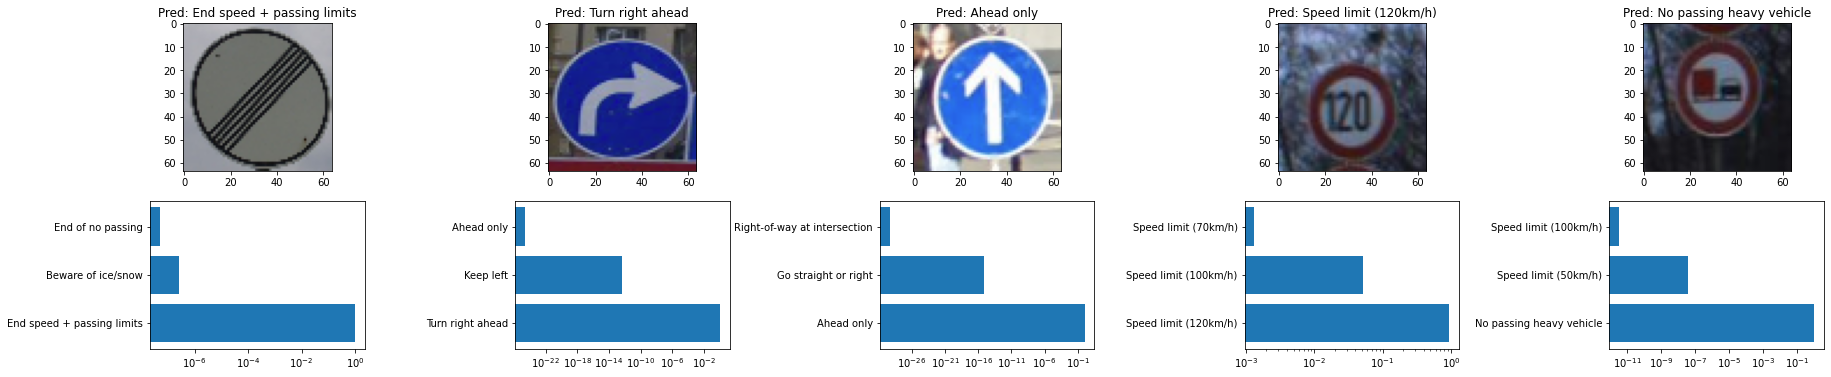

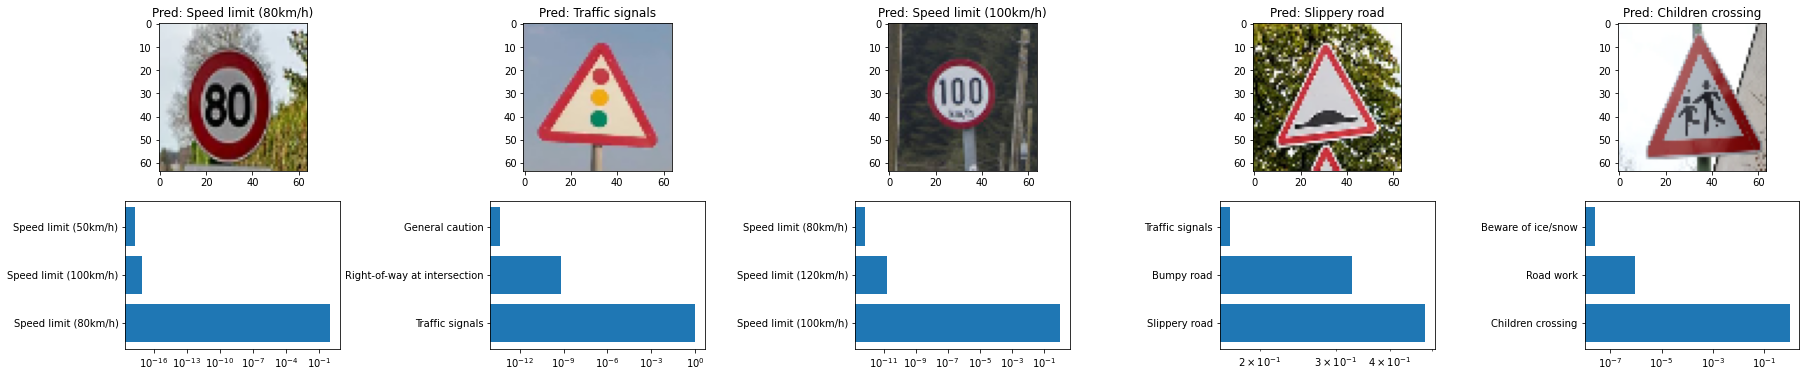

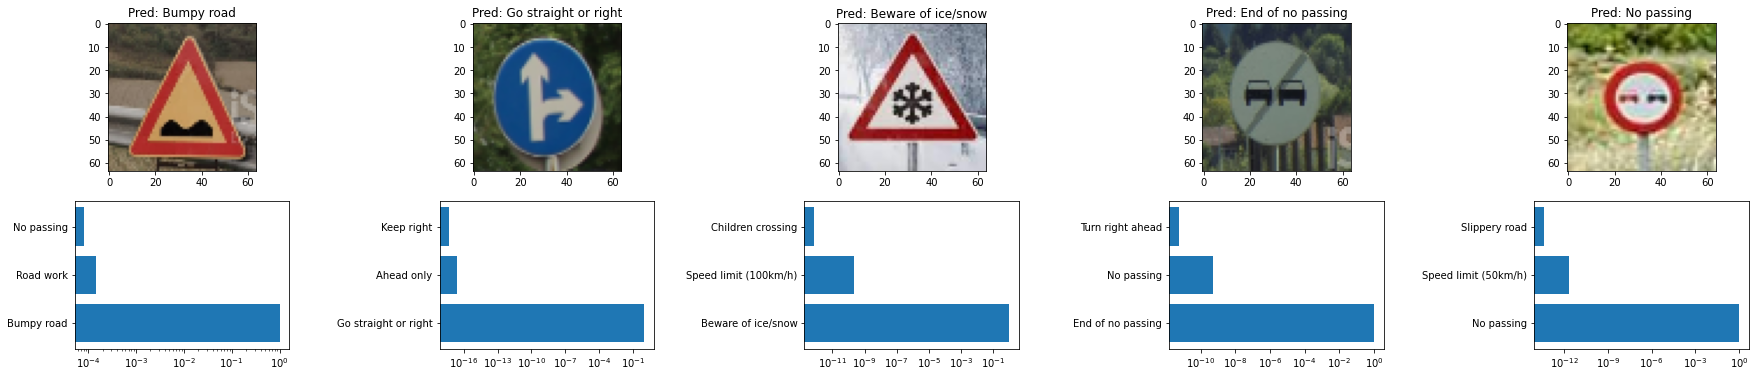

In [ ]:
#Función para generar un gráfico junto con la imagen que contenga las n predicciones con mayor porcentaje de precisión
def plot_results(test_images, model, class_names):
  for j in range(6):
    images_per_row = 5
    fig, axs = plt.subplots(2,images_per_row, figsize=(30,6))
    fig.subplots_adjust(wspace = 0.7)
    
    for i in range(images_per_row):
      n = 3 #considerar los n resultados mayores en las predicciones
      image = np.copy(test_images[i])
      image = np.expand_dims(image, axis=0)
      pred = model.predict(image)
      image = np.squeeze(image,axis=0)

      ind = (-pred[0]).argsort()[:n] #Indices ordenados de las señales con mayor porcentaje de prediccion
      values = pred[0][ind] #Porcentaje de predicción

      axs[0,i].imshow(image)
      axs[0,i].set_title(f'Pred: {class_names[ind[0]]}')

      axs[1,i].barh(range(n), values, log=True)
      axs[1,i].set_yticks(range(n))
      axs[1,i].set_yticklabels([class_names[i] for i in ind])

    add_images += images_per_row
    plt.show()

plot_results(test_images, CNN_custom, class_names)